# Correcting Virtual Silcton

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.api as sm
%matplotlib inline


# Data Import - *participant level* Master DF

In [2]:
path = '../CleanedData/masterDF.csv'
df = pd.read_csv(path, encoding = 'unicode_escape', sep = ",")

# Data Analysis - *participant level* Master DF

## Modeling data preparation

In [3]:
# IMPORTANT: according to the "correction machine logic", we 1) train on NEW data (where both good and bad pointing variables 
# are defined), and 2) we predict the "best guess" for the good_pointing_X variables on ORIGINAL data, 
# using the only information available, i.e., the bad_pointing_X variable.

In [25]:
def assembleData(df,x_vars,y_var):
    # Given a dataframe, provide names of x variables to use to fit the y variable.
    
    # we train only on NEW data
    df_train = df[df.New_or_Original=='New']
    df_train = df_train[np.concatenate((x_vars, [y_var]), axis=0)]
    df_train = df_train.dropna() # there are no NAs anyhow

    # we test only on Original data
    df_test = df[df.New_or_Original=='Original']
    df_test = df_test[np.concatenate((x_vars, [y_var]), axis=0)]
    df_test = df_test.dropna() # there are no NAs anyhow

    print('Training set shape: ',df_train.shape)
    print('Test set shape: ',df_test.shape)
    print('IVs: ',x_vars,'\nDV: ',y_var)

    X_train = df_train.drop(columns=[y_var])
    y_train = df_train[y_var]

    # test data
    X_test = df_test.drop(columns=[y_var])
    
    return X_train,y_train,X_test

## Select Variables Here! 

The variables you select below will be used in all remaining cells in the analyses. Feel free to use other columns in the Silcton dataset, though some may not behave well. The ones we've tested are listed below. 

In [29]:
x_vars = [
    #'bad_pointing_coding_within',
    'bad_pointing_coding_between',
    #'bad_pointing_coding_total' ,
    'SBSOD',
    'MRT'
]

# target
y_var = 'good_pointing_coding_between'

X_train,y_train,X_test = assembleData(df,x_vars,y_var)



Training set shape:  (91, 4)
Test set shape:  (294, 4)
IVs:  ['bad_pointing_coding_between', 'SBSOD', 'MRT'] 
DV:  good_pointing_coding_between


## Modeling: univariate regression

In [30]:
# We fit the model two ways in Python. Once to cross-validate (sklearn) and once for p-values. 

# For cross-validation purposes
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)


# p-values: alternative approach. We use statsmodels
X_train_p = sm.add_constant(X_train)
mod = sm.OLS(y_train,X_train_p)

fii = mod.fit()
print(fii.summary())

                                 OLS Regression Results                                 
Dep. Variable:     good_pointing_coding_between   R-squared:                       0.944
Model:                                      OLS   Adj. R-squared:                  0.943
Method:                           Least Squares   F-statistic:                     493.2
Date:                          Fri, 03 Sep 2021   Prob (F-statistic):           1.78e-54
Time:                                  17:15:54   Log-Likelihood:                -268.15
No. Observations:                            91   AIC:                             544.3
Df Residuals:                                87   BIC:                             554.3
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------

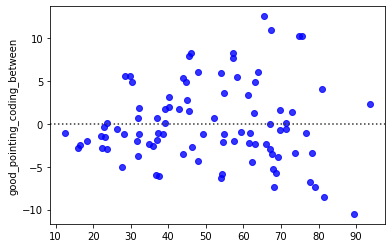

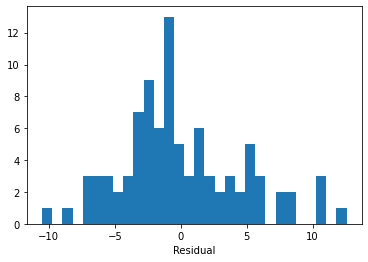

In [35]:
# PLOT RESIDUALS

# Plot the residuals after fitting a linear model
resid= sns.residplot(x=reg.predict(X_train), y=y_train, lowess=False, label=None, color="b")

figure = resid.get_figure()

fig,ax = plt.subplots()
plt.hist(y_train-reg.predict(X_train), bins = 30)
plt.xlabel('Residual')
plt.show()

In [36]:
# fitting best model to whole dataset *IN SAMPLE*
reg.fit(X_train, y_train)


print('R^2 on whole dataset')
print(r2_score(y_train, reg.predict(X_train)))
print('---------------------')
print('MSE on whole dataset')
print(mean_squared_error(y_train, reg.predict(X_train)))
print('---------------------')
print('MAE on whole dataset')
print(mean_absolute_error(y_train, reg.predict(X_train)))

R^2 on whole dataset
0.9444665436779156
---------------------
MSE on whole dataset
21.230718985342452
---------------------
MAE on whole dataset
3.6403708345561054


## Robustness of performance: cross-validation

In [37]:
# R2 is in-sample. Does it drop in presence of repeated cross-validation? If yes, can we quantify this drop? We do it
# for the univariate regression models.

In [38]:
# scorer
###############################################################
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

r2_scorer = make_scorer(r2_score)

# choice of scorer
scorer = r2_scorer

# random state
###############################################################
random_state=123
                            
# regressor (univariate linear regression)
###############################################################
clf = linear_model.LinearRegression()
    
# GRID SEARCH
##############################################################

# pipeline
pipe = Pipeline([('clf', clf)])

# PARAMETER GRID - we do nothing
##############################################################
param_grid = {}

# The repeated k-fold
##############################################################
n_folds=5     
n_repeats=100  

skfold = RepeatedKFold(n_splits=n_folds,
                       n_repeats=n_repeats,
                       random_state=random_state)

# GRID SEARCH
#############################################################
grid_clf = GridSearchCV(pipe, 
                        param_grid,
                        scoring=scorer,
                        cv=skfold, 
                        verbose=5)
                        
# RUNNING THE GRID
############################################
grid_clf.fit(X_train, y_train) 

Fitting 500 folds for each of 1 candidates, totalling 500 fits
[CV]  ................................................................
[CV] .................................... , score=0.953, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.935, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.952, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.905, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.946, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.952, total=   0.0s
[CV]  ................................................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s



[CV] .................................... , score=0.954, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.929, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.942, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.952, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.936, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.952, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.919, total=   0.0s
[CV]  ................................................................
[CV] 

[CV] .................................... , score=0.919, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.873, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.921, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.941, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.943, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.895, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.960, total=   0.0s
[CV]  ................................................................
[CV] .

[CV] .................................... , score=0.875, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.982, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.911, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.944, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.947, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.950, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.951, total=   0.0s
[CV]  ................................................................
[CV] .

[CV] .................................... , score=0.932, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.927, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.916, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.887, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.945, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.925, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.938, total=   0.0s
[CV]  ................................................................
[CV] .

[CV] .................................... , score=0.926, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.950, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.951, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.933, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.914, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.941, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.919, total=   0.0s
[CV]  ................................................................
[CV] .

[CV] .................................... , score=0.909, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.962, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.940, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.932, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.935, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.933, total=   0.0s
[CV]  ................................................................
[CV] .................................... , score=0.945, total=   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


GridSearchCV(cv=RepeatedKFold(n_repeats=100, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('clf', LinearRegression())]),
             param_grid={}, scoring=make_scorer(r2_score), verbose=5)

In [39]:
# COLLECTING RESULTS
##############################################################

# best estimator
clf_b = grid_clf.best_estimator_

# print results
print('-------------------------------------------------------')
print('-------------------------------------------------------')
print('Best parameters:', grid_clf.best_params_)
print('-------------------------------------------------------')
print('-------------------------------------------------------')
print('Mean performance (and standard deviation):')
print(grid_clf.cv_results_['mean_test_score'][grid_clf.best_index_])
print(grid_clf.cv_results_['std_test_score'][grid_clf.best_index_])

-------------------------------------------------------
-------------------------------------------------------
Best parameters: {}
-------------------------------------------------------
-------------------------------------------------------
Mean performance (and standard deviation):
0.9320160602954475
0.025595622308631105


In [40]:
# We can compare those numbers to the values below. 
clf_b.fit(X_train, y_train)

print('R^2 on whole dataset')
print(r2_score(y_train, clf_b.predict(X_train)))
print('---------------------')
print('MSE on whole dataset')
print(mean_squared_error(y_train, clf_b.predict(X_train)))
print('---------------------')
print('MAE on whole dataset')
print(mean_absolute_error(y_train, clf_b.predict(X_train)))

R^2 on whole dataset
0.9444665436779156
---------------------
MSE on whole dataset
21.230718985342452
---------------------
MAE on whole dataset
3.6403708345561054


## Modeling: easy regression tree

In [41]:
# scorer
###############################################################

r2_scorer = make_scorer(r2_score)
mean_sq_scorer = make_scorer(mean_squared_error, greater_is_better=False) # important: the higher, the worse
mean_ab_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# choice of scorer
#scorer = mean_sq_scorer
scorer = r2_scorer

# random state
###############################################################
random_state=123
                            
# regressor
###############################################################
clf = DecisionTreeRegressor(random_state=random_state)
    
# GRID SEARCH
##############################################################

# pipeline
pipe = Pipeline([('clf', clf)])

# PARAMETER GRID
##############################################################
param_grid = {'clf__max_depth': [1, 2, 3, 4, 5, 6, 7]}

# # THE REPEATED K FOLD
# #########################################
n_folds=5     #5
n_repeats=100  #50

skfold = RepeatedKFold(n_splits=n_folds,
                        n_repeats=n_repeats,
                        random_state=random_state)

# GRID SEARCH
#############################################
grid_clf = GridSearchCV(pipe, 
                        param_grid,
                        scoring=scorer,
                        cv=skfold, 
                        verbose=5)
                        
# RUNNING THE GRID
############################################
grid_clf.fit(X_train, y_train) 

Fitting 500 folds for each of 7 candidates, totalling 3500 fits
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.704, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.759, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.664, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.621, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.659, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.681, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV] .................... clf__max_depth=1, score=0.702, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.649, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.581, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.555, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.696, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.642, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.487, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .

[CV] .................... clf__max_depth=1, score=0.672, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.681, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.644, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.553, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.587, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.701, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.769, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .

[CV] .................... clf__max_depth=1, score=0.460, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.533, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.612, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.843, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.661, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.690, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.705, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .

[CV] .................... clf__max_depth=1, score=0.829, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.602, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.554, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.525, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.767, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.549, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.787, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .

[CV] .................... clf__max_depth=1, score=0.396, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.611, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.653, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.714, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.371, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.712, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.764, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .

[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.641, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.769, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.519, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.585, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.601, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.697, total=   0.0s
[CV] clf__max_depth=1 ................................................
[CV] .................... clf__max_depth=1, score=0.770, total=   0.0s
[CV] c

[CV] .................... clf__max_depth=2, score=0.827, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.733, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.828, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.810, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.860, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.825, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.872, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.841, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.882, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.749, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.797, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.855, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.826, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.796, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.735, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.770, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.830, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.859, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.697, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.820, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.886, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.876, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.820, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.710, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.809, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.840, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.852, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.840, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.807, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.753, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.765, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.858, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.792, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.811, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.837, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.773, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.629, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.812, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.814, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.862, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.709, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.826, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=2, score=0.826, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.846, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.801, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.815, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.828, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.676, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .................... clf__max_depth=2, score=0.808, total=   0.0s
[CV] clf__max_depth=2 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.913, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.910, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.889, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.833, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.868, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.870, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.911, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.956, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.892, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.868, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.943, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.894, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.898, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.847, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.857, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.919, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.937, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.829, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.852, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.888, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.873, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.861, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.913, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.825, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.885, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.904, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.906, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.937, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.881, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.938, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.749, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.840, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.931, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.888, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.867, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=3, score=0.903, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.898, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.928, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.887, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.776, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.824, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .................... clf__max_depth=3, score=0.919, total=   0.0s
[CV] clf__max_depth=3 ................................................
[CV] .

[CV] .................... clf__max_depth=4, score=0.880, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.863, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.878, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.925, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.913, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.841, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.857, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .

[CV] .................... clf__max_depth=4, score=0.715, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.907, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.931, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.930, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.938, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.769, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.850, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .

[CV] .................... clf__max_depth=4, score=0.902, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.819, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.930, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.894, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.876, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.905, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.880, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .

[CV] .................... clf__max_depth=4, score=0.895, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.892, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.892, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.837, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.851, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.892, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.912, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .

[CV] .................... clf__max_depth=4, score=0.873, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.824, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.909, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.904, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.859, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.782, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .................... clf__max_depth=4, score=0.919, total=   0.0s
[CV] clf__max_depth=4 ................................................
[CV] .

[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.880, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.872, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.853, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.787, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.874, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.914, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.893, total=   0.0s
[CV] c

[CV] .................... clf__max_depth=5, score=0.957, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.732, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.913, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.921, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.807, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.911, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.794, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .

[CV] .................... clf__max_depth=5, score=0.763, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.891, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.856, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.756, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.839, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.944, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.623, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .

[CV] .................... clf__max_depth=5, score=0.907, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.935, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.893, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.880, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.887, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.590, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.898, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .

[CV] .................... clf__max_depth=5, score=0.863, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.855, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.814, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.921, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.883, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.854, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .................... clf__max_depth=5, score=0.889, total=   0.0s
[CV] clf__max_depth=5 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.866, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.663, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.940, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.832, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.857, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.827, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.761, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.821, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.923, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.950, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.639, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.882, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.878, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.792, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.866, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.748, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.902, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.862, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.730, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.808, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.937, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.871, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.900, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.908, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.890, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.872, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.812, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.847, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.911, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.926, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.898, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.912, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.865, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.830, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.813, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=6, score=0.889, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.895, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.765, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.872, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.914, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.818, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .................... clf__max_depth=6, score=0.839, total=   0.0s
[CV] clf__max_depth=6 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.805, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.894, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.757, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.775, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.864, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.872, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.825, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.928, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.873, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.912, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.814, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.860, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.954, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.683, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.921, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.902, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.827, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.885, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.921, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.879, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.761, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.753, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.622, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.937, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.839, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.909, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.867, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.879, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.806, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.930, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.860, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.908, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.917, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.873, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.850, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.748, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.751, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.882, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.767, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.780, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.914, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.854, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[CV] .................... clf__max_depth=7, score=0.575, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.877, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.811, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.733, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.862, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.924, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .................... clf__max_depth=7, score=0.819, total=   0.0s
[CV] clf__max_depth=7 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 3500 out of 3500 | elapsed:   24.3s finished


GridSearchCV(cv=RepeatedKFold(n_repeats=100, n_splits=5, random_state=123),
             estimator=Pipeline(steps=[('clf',
                                        DecisionTreeRegressor(random_state=123))]),
             param_grid={'clf__max_depth': [1, 2, 3, 4, 5, 6, 7]},
             scoring=make_scorer(r2_score), verbose=5)

In [42]:
# COLLECTING RESULTS
##############################################################

# best estimator
clf_b = grid_clf.best_estimator_

# print results
print('-------------------------------------------------------')
print('-------------------------------------------------------')
print('Best parameters:', grid_clf.best_params_)
print('-------------------------------------------------------')
print('-------------------------------------------------------')
print('Mean performance (and standard deviation):')
print(grid_clf.cv_results_['mean_test_score'][grid_clf.best_index_])
print(grid_clf.cv_results_['std_test_score'][grid_clf.best_index_])

-------------------------------------------------------
-------------------------------------------------------
Best parameters: {'clf__max_depth': 3}
-------------------------------------------------------
-------------------------------------------------------
Mean performance (and standard deviation):
0.8792203027814165
0.046141405115956574


In [43]:
# analysis tree
clf = clf_b.named_steps['clf']

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}node={node} is a leaf node.".format(
            space=node_depth[i] * "\t", node=i))
    else:
        print("{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i]))

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 34.58012390136719 else to node 8.
	node=1 is a split node: go to node 2 if X[:, 0] <= 21.881601333618164 else to node 5.
		node=2 is a split node: go to node 3 if X[:, 0] <= 15.565065383911133 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[:, 0] <= 30.704262733459473 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[:, 0] <= 52.13438034057617 else to node 12.
		node=9 is a split node: go to node 10 if X[:, 0] <= 43.387550354003906 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[:, 0] <= 57.863821029663086 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf node.


# Linear Regressions with Random Regressors

In [44]:
# Here we reintroduce the simple versions of the models.  
######################################################

# We train only on new data
df_train = df[df.New_or_Original=='New']

# Separate models for within and between 
X_train_within = df_train[['bad_pointing_coding_within']]
y_train_within = df_train[['good_pointing_coding_within']]

# Original OLS models with LinearRegression()
within_model = linear_model.LinearRegression()
within_model.fit(X_train_within,y_train_within)

X_train_between = df_train[['bad_pointing_coding_between']]
y_train_between = df_train[['good_pointing_coding_between']]

between_model = linear_model.LinearRegression()
between_model.fit(X_train_between,y_train_between)

LinearRegression()

In [45]:
# random seed
random.seed(10)

# idea: generate K>=1 random vectors, run again OLS and check that R^2 sequentially improve. 
# For each model with random vector, compute the pearson correlation N times, and plot it
# how to generate random vectors? Let us have a look at the distribution of bad_pointing_coding_within/between

print(X_train_within.bad_pointing_coding_within.describe())
print('------------------')
print(X_train_between.bad_pointing_coding_between.describe())

# ---> let us take uniform distributions in the same intervals. Preliminary investigations lead to no improvement 
#      (and not stat. sign. coefficients) with uniform [-1,1], [0,1] and normal [0,1]

count    147.000000
mean      17.952571
std       11.400765
min        2.793162
25%        8.822598
50%       15.649600
75%       23.117784
max       52.775495
Name: bad_pointing_coding_within, dtype: float64
------------------
count    147.000000
mean      40.460078
std       16.111634
min       10.318132
25%       26.993580
50%       43.350128
75%       53.288671
max       74.049082
Name: bad_pointing_coding_between, dtype: float64


## Within model

In [46]:
# one random vector: choose the distribution and the parameters
###############################################################

# for uniform distribution
min_within = X_train_within.bad_pointing_coding_within.min()
max_within = X_train_within.bad_pointing_coding_within.max()

# for normal distributions
mean = X_train_within.bad_pointing_coding_within.mean()
std = X_train_within.bad_pointing_coding_within.std()

# generating the random vector (choose the distribution)
X_train_within['randNum_1'] = np.random.uniform(min_within, max_within ,X_train_within.shape[0])
#X_train_within['randNum_1'] = np.random.normal(mean, std, X_train_within.shape[0])

# new model with random vector/variable
X_train_within_p = sm.add_constant(X_train_within)
mod_within_rnd_1 = sm.OLS(y_train_within, X_train_within_p)
mod_within_rnd_1_fit = mod_within_rnd_1.fit()

# results
print(mod_within_rnd_1_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:     good_pointing_coding_within   R-squared:                       0.932
Model:                                     OLS   Adj. R-squared:                  0.931
Method:                          Least Squares   F-statistic:                     979.6
Date:                         Fri, 03 Sep 2021   Prob (F-statistic):           1.43e-84
Time:                                 17:17:52   Log-Likelihood:                -428.26
No. Observations:                          147   AIC:                             862.5
Df Residuals:                              144   BIC:                             871.5
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

C:\Users\smwei\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


C:\Users\smwei\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\smwei\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


---------------------
---------------------
Distribution coefficients bad pointing
---------------------
---------------------
count    1000.000000
mean        1.446740
std         0.002818
min         1.429589
25%         1.445680
50%         1.446824
75%         1.447802
max         1.463556
Name: coeff_bad_pointing, dtype: float64
---------------------
count    1000.000000
mean        1.446754
std         0.002693
min         1.436349
25%         1.445796
50%         1.446827
75%         1.447683
max         1.470406
Name: coeff_bad_pointing, dtype: float64
---------------------
---------------------
Distribution R^2
---------------------
---------------------
count    1000.000000
mean        0.932010
std         0.000697
min         0.931507
25%         0.931559
50%         0.931721
75%         0.932171
max         0.936622
Name: rsquared, dtype: float64
---------------------
count    1000.000000
mean        0.931968
std         0.000645
min         0.931507
25%         0.931551
50

Text(0, 0.5, '')

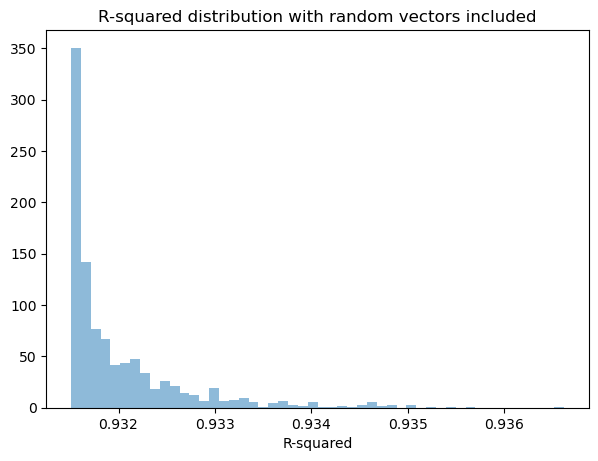

In [47]:
## Analysis of coefficients, for many runs of the random vectors
#################################################################

# collecting all relevant distrb. paramters

# uniform
min_within = X_train_within.bad_pointing_coding_within.min()
max_within = X_train_within.bad_pointing_coding_within.max()

# normal
mean = X_train_within.bad_pointing_coding_within.mean()
std = X_train_within.bad_pointing_coding_within.std()


####################################################################################################
# uniform distributions (change parameters)
a=-1   #-1,0, or min_within
b=1   #   1, or max_within

data_u = []

for i in range(0,1000):
    
    X_train_within['randNum_1'] = np.random.uniform(a, b, X_train_within.shape[0])
    
    # new model with random vector/variable
    X_train_within_p = sm.add_constant(X_train_within)
    mod_within_rnd_1 = sm.OLS(y_train_within, X_train_within_p)
    mod_within_rnd_1_fit = mod_within_rnd_1.fit()
    
    # collecting results
    data_u.append([a, b, mod_within_rnd_1_fit.params[0], 
                   mod_within_rnd_1_fit.params[1], mod_within_rnd_1_fit.params[2],
                   mod_within_rnd_1_fit.rsquared])

# results as a dataframe
results_within_uniform = pd.DataFrame(data_u, columns=['a_uniform', 'b_uniform', 'coeff_intercept', 
                                                       'coeff_bad_pointing', 'coeff_random_vector',
                                                       'rsquared'])



####################################################################################################
# normal distributions (change parameters)
mean=mean       #   0 or  mean
std=std     #   1, or std

data_n = []

for i in range(0,1000):
    
    X_train_within['randNum_1'] = np.random.normal(mean, std, X_train_within.shape[0])
    
    # new model with random vector/variable
    X_train_within_p = sm.add_constant(X_train_within)
    mod_within_rnd_1 = sm.OLS(y_train_within, X_train_within_p)
    mod_within_rnd_1_fit = mod_within_rnd_1.fit()
    
    # collecting results
    data_n.append([mean, std, mod_within_rnd_1_fit.params[0], 
                   mod_within_rnd_1_fit.params[1], mod_within_rnd_1_fit.params[2],
                   mod_within_rnd_1_fit.rsquared])

# results as a dataframe
results_within_normal = pd.DataFrame(data_n, columns=['mean_normal', 'std_normal', 'coeff_intercept', 
                                                      'coeff_bad_pointing', 'coeff_random_vector', 
                                                      'rsquared'])

print('---------------------')
print('---------------------')
print('Distribution coefficients bad pointing')
print('---------------------')
print('---------------------')
print(results_within_uniform.coeff_bad_pointing.describe())
print('---------------------')
print(results_within_normal.coeff_bad_pointing.describe())
print('---------------------')
print('---------------------')
print('Distribution R^2')
print('---------------------')
print('---------------------')
print(results_within_uniform.rsquared.describe())
print('---------------------')
print(results_within_normal.rsquared.describe())

# plotting

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Normalize
kwargs = dict(alpha=0.5, bins=50, density=False)

plt.hist(results_within_uniform.rsquared, **kwargs)

plt.title('R-squared distribution with random vectors included')
plt.xlabel("R-squared")
plt.ylabel("")


## Between Model

In [ ]:
# Analysis of coefficients, for many runs of the random vectors
################################################################

# collecting all relevant distrb. paramters

# uniform
min_between = X_train_between.bad_pointing_coding_between.min()
max_between = X_train_between.bad_pointing_coding_between.max()

# normal
mean = X_train_between.bad_pointing_coding_between.mean()
std = X_train_between.bad_pointing_coding_between.std()


####################################################################################################
# uniform distributions (change parameters)
a=min_within #min_between   #-1,0, or min_within
b=max_within #max_between  #   1, or max_within

data_u = []

for i in range(0,1000):
    
    X_train_between['randNum_1'] = np.random.uniform(a, b, X_train_between.shape[0])
    
    # new model with random vector/variable
    X_train_between_p = sm.add_constant(X_train_between)
    mod_between_rnd_1 = sm.OLS(y_train_between, X_train_between_p)
    mod_between_rnd_1_fit = mod_between_rnd_1.fit()
    
    # collecting results
    data_u.append([a, b, mod_between_rnd_1_fit.params[0], 
                   mod_between_rnd_1_fit.params[1], mod_between_rnd_1_fit.params[2],
                   mod_between_rnd_1_fit.rsquared])

# results as a dataframe
results_between_uniform = pd.DataFrame(data_u, columns=['a_uniform', 'b_uniform', 'coeff_intercept', 
                                                        'coeff_bad_pointing', 'coeff_random_vector',
                                                        'rsquared'])


####################################################################################################
# normal distributions (change parameters)
mean=mean # mean       #   0 or  mean
std=std  #std         #   1, or std

data_n = []

for i in range(0,1000):
    
    X_train_between['randNum_1'] = np.random.normal(0, 1, X_train_between.shape[0])
    
    # new model with random vector/variable
    X_train_between_p = sm.add_constant(X_train_between)
    mod_between_rnd_1 = sm.OLS(y_train_between, X_train_between_p)
    mod_between_rnd_1_fit = mod_between_rnd_1.fit()

    
    # collecting results
    data_n.append([mean, std, mod_between_rnd_1_fit.params[0], 
                   mod_between_rnd_1_fit.params[1], mod_between_rnd_1_fit.params[2],
                   mod_between_rnd_1_fit.rsquared])

# results as a dataframe
results_between_normal = pd.DataFrame(data_n, columns=['mean_normal', 'std_normal', 'coeff_intercept', 
                                                       'coeff_bad_pointing', 'coeff_random_vector',
                                                       'rsquared'])

print('---------------------')
print('---------------------')
print('Distribution coefficients bad pointing')
print('---------------------')
print('---------------------')
print(results_between_uniform.coeff_bad_pointing.describe())
print('---------------------')
print(results_between_normal.coeff_bad_pointing.describe())
print('---------------------')
print('---------------------')
print('Distribution R^2')
print('---------------------')
print('---------------------')
print(results_between_uniform.rsquared.describe())
print('---------------------')
print(results_between_normal.rsquared.describe())

# plotting
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Normalize
kwargs = dict(alpha=0.5, bins=50, density=False)

plt.hist(results_between_uniform.rsquared, **kwargs)

plt.title('R-squared distribution with random vectors included')
plt.xlabel("R-squared")
plt.ylabel("")
